# CP2K Defect Finite Size Correction (eFNV)

This Jupyter notebook calculates the **extended Freysoldt-Neugebauer-Van de Walle (eFNV)** correction for charged defect supercells using cube files from **CP2K**.

It is adapted from the [doped](https://github.com/SMTG-Bham/doped) package, which is designed for VASP defect calculations. With this notebook you can use CP2K cube files (e.g., Hartree potential) to effectivelly compute both electrostatic and potential alignment corrections.

## Citation

This notebook is derived from [doped](https://github.com/SMTG-Bham/doped), licensed under the MIT License (Copyright © 2021 Seán Kavanagh).

If you use this note book for your defect modeling please cite the following two papers:

Kavanagh et al., (2024). doped: Python toolkit for robust and repeatable charged defect supercell calculations. Journal of Open Source Software, 9(96), 6433, https://doi.org/10.21105/joss.06433

and

"Insights into oxygen vacancies from high-throughput first-principles calculations"
Yu Kumagai, Naoki Tsunoda, Akira Takahashi, and Fumiyasu Oba
Phys. Rev. Materials 5, 123803 (2021)





## Background
The eFNV correction include:
- **Potential Alignment**: Aligns the electrostatic potential between bulk and defect supercells.
- **Charge Correction**: Computes the energy for a charged defect in a periodic supercell, adjusted by the dielectric constant.


This implementation uses CP2K cube files (e.g., Hartree potential) instead of VASP's CHGCAR/LOCPOT. CP2K cube files are parsed using `pymatgen.io.cube`. Note that CP2K potentials are typically in Hartree, so unit conversions (Hartree to eV) are applied where necessary.



## Install Dependencies

In [ ]:
!pip install pydefect pymatgen ase

## Upload Cube Files for Atomic Site Potential

The bulk and defect files should have the same supercell size and grid.
The following code matches atoms between the two structures and calculates potential differences at atomic sites using interpolation

In [24]:
import numpy as np
from ase.io.cube import read_cube_data
from scipy.spatial import distance_matrix
import csv

# File paths
output_file = "potential_difference_vs_distance.csv"
pristine_cube_file = "/path/to/your/pristine/cube_file.cube"
defective_cube_file = "/path/to/your/defective/cube_file.cube"



# Conversion factor from Hartree to eV
HARTREE_TO_EV = 27.2113838565563

# Distance threshold for matching atoms (in Ångstroms)
DISTANCE_THRESHOLD = 0.5
DEFECTIVE_ELEMENTS = []
DEFECTIVE_INDICES = []
# Use centroid of defective atoms for distance calculation if multiple defects
USE_DEFECT_CENTROID = False  # Set to False since single defect position is used

# Read cube files
try:
    pristine_potential, pristine_atoms = read_cube_data(pristine_cube_file)
    defective_potential, defective_atoms = read_cube_data(defective_cube_file)
    print(f"Read {len(pristine_atoms)} atoms from pristine {pristine_cube_file}")
    print(f"Read {len(defective_atoms)} atoms from defective {defective_cube_file}")
except Exception as e:
    print(f"Error reading .cube file: {e}")
    raise

# Get grid dimensions and voxel vectors
nx_p, ny_p, nz_p = pristine_potential.shape
voxel_p = pristine_atoms.cell / np.array([nx_p, ny_p, nz_p])
nx_d, ny_d, nz_d = defective_potential.shape
voxel_d = defective_atoms.cell / np.array([nx_d, ny_d, nz_d])

# Function to interpolate potential at a given position
def interpolate_potential(pos, potential, voxel, origin=np.array([0, 0, 0])):
    try:
        grid_pos = (pos - origin) @ np.linalg.inv(voxel)
        grid_pos = np.clip(grid_pos, 0, np.array([potential.shape[0]-1, potential.shape[1]-1, potential.shape[2]-1]))
        i, j, k = np.floor(grid_pos).astype(int)
        fx, fy, fz = grid_pos - np.array([i, j, k])
        v000 = potential[i, j, k]
        v100 = potential[min(i+1, potential.shape[0]-1), j, k]
        v010 = potential[i, min(j+1, potential.shape[1]-1), k]
        v110 = potential[min(i+1, potential.shape[0]-1), min(j+1, potential.shape[1]-1), k]
        v001 = potential[i, j, min(k+1, potential.shape[2]-1)]
        v101 = potential[min(i+1, potential.shape[0]-1), j, min(k+1, potential.shape[2]-1)]
        v011 = potential[i, min(j+1, potential.shape[1]-1), min(k+1, potential.shape[2]-1)]
        v111 = potential[min(i+1, potential.shape[0]-1), min(j+1, potential.shape[1]-1), min(k+1, potential.shape[2]-1)]
        v00 = v000 * (1 - fx) + v100 * fx
        v01 = v001 * (1 - fx) + v101 * fx
        v10 = v010 * (1 - fx) + v110 * fx
        v11 = v011 * (1 - fx) + v111 * fx
        v0 = v00 * (1 - fy) + v10 * fy
        v1 = v01 * (1 - fy) + v11 * fy
        v = v0 * (1 - fz) + v1 * fz
        return v
    except Exception as e:
        print(f"Error interpolating potential at position {pos}: {e}")
        return None

# Match atoms between pristine and defective structures
def match_atoms(pristine_atoms, defective_atoms, threshold=DISTANCE_THRESHOLD):
    pristine_positions = pristine_atoms.get_positions()
    defective_positions = defective_atoms.get_positions()
    dist_matrix = distance_matrix(pristine_positions, defective_positions)
    matches = []
    used_defective = set()
    for i in range(len(pristine_atoms)):
        min_dist = np.min(dist_matrix[i])
        if min_dist < threshold:
            j = np.argmin(dist_matrix[i])
            if j not in used_defective:
                matches.append((i, j))
                used_defective.add(j)
    return matches

# Get matched atoms
matches = match_atoms(pristine_atoms, defective_atoms)
print(f"Found {len(matches)} matched atoms between pristine and defective structures")

# Identify excluded atoms
matched_pristine_indices = [m[0] for m in matches]
matched_defective_indices = [m[1] for m in matches]
pristine_excluded = [i for i in range(len(pristine_atoms)) if i not in matched_pristine_indices or
                     i in DEFECTIVE_INDICES or pristine_atoms[i].symbol in DEFECTIVE_ELEMENTS]
defective_excluded = [i for i in range(len(defective_atoms)) if i not in matched_defective_indices or
                      i in DEFECTIVE_INDICES or defective_atoms[i].symbol in DEFECTIVE_ELEMENTS]
print(f"Excluded {len(pristine_excluded)} pristine atoms and {len(defective_excluded)} defective atoms")

# Get coordinates of defective atoms
defective_positions = []
if defective_excluded:
    defective_positions = [defective_atoms[idx].position for idx in defective_excluded]
    print("\nExcluded Defective Atoms Coordinates:")
    for idx, pos in zip(defective_excluded, defective_positions):
        print(f"Atom {defective_atoms[idx].symbol} (Index {idx}): X={pos[0]:.6f}, Y={pos[1]:.6f}, Z={pos[2]:.6f}")
else:
    defective_positions = [pristine_atoms[idx].position for idx in pristine_excluded]
    print("\nNo excluded defective atoms; using unmatched pristine atoms as defect positions:")
    for idx, pos in zip(pristine_excluded, defective_positions):
        print(f"Atom {pristine_atoms[idx].symbol} (Index {idx}): X={pos[0]:.6f}, Y={pos[1]:.6f}, Z={pos[2]:.6f}")

# Calculate defect centroid if multiple defects and USE_DEFECT_CENTROID is True
if len(defective_positions) > 1 and USE_DEFECT_CENTROID:
    defect_reference = np.mean(defective_positions, axis=0)
    print(f"\nUsing centroid of defective atoms: X={defect_reference[0]:.6f}, Y={defect_reference[1]:.6f}, Z={defect_reference[2]:.6f}")
else:
    defect_reference = defective_positions[0] if defective_positions else np.array([0, 0, 0])
    print(f"\nUsing single defect position: X={defect_reference[0]:.6f}, Y={defect_reference[1]:.6f}, Z={defect_reference[2]:.6f}")

# Compute potentials, distances, and differences
pristine_potentials = []
defective_potentials = []
distances = []
valid_matches = []
print("\nAtom\tX\tY\tZ\tPristine Potential (eV)\tDefective Potential (eV)\tDifference (eV)\tDistance from Defect (Å)")
with open(output_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Atom", "X", "Y", "Z", "Pristine Potential (eV)", "Defective Potential (eV)",
                        "Difference (eV)", "Distance from Defect (Å)"])

    for pristine_idx, defective_idx in matches:
        if (pristine_idx in DEFECTIVE_INDICES or defective_idx in DEFECTIVE_INDICES or
            pristine_atoms[pristine_idx].symbol in DEFECTIVE_ELEMENTS or
            defective_atoms[defective_idx].symbol in DEFECTIVE_ELEMENTS):
            continue
        pos = pristine_atoms[pristine_idx].position
        pristine_potential_hartree = interpolate_potential(pos, pristine_potential, voxel_p)
        defective_potential_hartree = interpolate_potential(pos, defective_potential, voxel_d)
        if pristine_potential_hartree is not None and defective_potential_hartree is not None:
            pristine_potential_eV = pristine_potential_hartree * HARTREE_TO_EV
            defective_potential_eV = defective_potential_hartree * HARTREE_TO_EV
            diff = defective_potential_eV - pristine_potential_eV
            distance = np.linalg.norm(pos - defect_reference)
            pristine_potentials.append(pristine_potential_eV)
            defective_potentials.append(defective_potential_eV)
            distances.append(distance)
            valid_matches.append((pristine_idx, defective_idx))
            #print(f"{pristine_atoms[pristine_idx].symbol}\t{pos[0]:.6f}\t{pos[1]:.6f}\t{pos[2]:.6f}\t"
            #      f"{pristine_potential_eV:.6f}\t{defective_potential_eV:.6f}\t{diff:.6f}\t{distance:.6f}")
            csv_writer.writerow([pristine_atoms[pristine_idx].symbol, f"{pos[0]:.6f}", f"{pos[1]:.6f}", f"{pos[2]:.6f}",
                                f"{pristine_potential_eV:.6f}", f"{defective_potential_eV:.6f}", f"{diff:.6f}", f"{distance:.6f}"])
        else:
            print(f"Skipping atom {pristine_atoms[pristine_idx].symbol} at {pos} due to interpolation error")

Read 540 atoms from pristine /content/drive/MyDrive/Defect/cp2k/Al2O3-PBE0-332-v_hartree-1_0.cube
Read 539 atoms from defective /content/drive/MyDrive/Defect/cp2k/Al2O3-eVacO-PBE0-ENERGY-332-v_hartree-1_0.cube
Found 539 matched atoms between pristine and defective structures
Excluded 1 pristine atoms and 0 defective atoms

No excluded defective atoms; using unmatched pristine atoms as defect positions:
Atom O (Index 286): X=3.302372, Y=5.486213, Z=14.072419

Using single defect position: X=3.302372, Y=5.486213, Z=14.072419

Atom	X	Y	Z	Pristine Potential (eV)	Defective Potential (eV)	Difference (eV)	Distance from Defect (Å)


## Compute Electrostatic Correction and Potential Alignment

In [25]:
import numpy as np
from pymatgen.core import Structure, Lattice
from pydefect.analyzer.calc_results import CalcResults
from pydefect.analyzer.defect_structure_comparator import DefectStructureComparator
from pydefect.cli.vasp.make_efnv_correction import calc_max_sphere_radius
from pydefect.corrections.efnv_correction import ExtendedFnvCorrection, PotentialSite
from pydefect.corrections.ewald import Ewald
from pydefect.corrections.site_potential_plotter import SitePotentialMplPlotter
import matplotlib.pyplot as plt
from ase import Atoms

def ase_to_pymatgen(ase_atoms):
    """Convert ASE Atoms to pymatgen Structure."""
    lattice = Lattice(ase_atoms.cell)
    species = [atom.symbol for atom in ase_atoms]
    coords = ase_atoms.get_positions()
    return Structure(lattice, species, coords, coords_are_cartesian=True)

def get_kumagai_correction_from_cube(
    pristine_atoms: Atoms,
    defective_atoms: Atoms,
    pristine_potentials: list,
    defective_potentials: list,
    valid_matches: list,
    defect_reference: np.ndarray,
    dielectric: float | np.ndarray,
    charge: int,
    defect_region_radius: float | None = None,
    excluded_indices: list | None = None,
    verbose: bool = True,
    plot: bool = False,
    filename: str | None = "kumagai_potential_plot.png"
) -> dict:
    """
    Compute Kumagai (eFNV) finite-size charge correction using data from .cube files.

    Args:
        pristine_atoms (Atoms): ASE Atoms object for the bulk supercell.
        defective_atoms (Atoms): ASE Atoms object for the defect supercell.
        pristine_potentials (list): Electrostatic potentials (eV) at bulk supercell sites.
        defective_potentials (list): Electrostatic potentials (eV) at defect supercell sites.
        valid_matches (list): List of tuples (pristine_idx, defective_idx) for matched atoms with valid potentials.
        defect_reference (np.ndarray): Cartesian coordinates (Å) of the defect (single or centroid).
        dielectric (float or np.ndarray): Dielectric constant (scalar or 3x3 tensor).
        charge (int): Charge state of the defect (e.g., -1 for v_O^-1).
        defect_region_radius (float): Radius (Å) for defect region exclusion.
        excluded_indices (list): List of site indices to exclude from sampling.
        verbose (bool): Whether to print correction energy.
        plot (bool): Whether to generate and show the potential plot.
        filename (str): Filename to save the plot. If None, plot is not saved.

    Returns:
        dict: Dictionary with correction energy, metadata, and optionally the matplotlib figure.
    """
    # Convert ASE Atoms to pymatgen Structures
    defect_supercell = ase_to_pymatgen(defective_atoms)
    bulk_supercell = ase_to_pymatgen(pristine_atoms)

    # Remove oxidation states as required by pydefect
    defect_supercell.remove_oxidation_states()
    bulk_supercell.remove_oxidation_states()

    # Ensure dielectric is a 3x3 tensor
    if isinstance(dielectric, (float, int)):
        dielectric = np.array([[dielectric, 0, 0], [0, dielectric, 0], [0, 0, dielectric]])
    elif isinstance(dielectric, (list, np.ndarray)):
        dielectric = np.array(dielectric)
        if dielectric.shape == (3,):
            dielectric = np.diag(dielectric)
        elif dielectric.shape != (3, 3):
            raise ValueError("Dielectric must be a scalar, 3x1, or 3x3 matrix.")

    # Create CalcResults objects
    defect_calc_results = CalcResults(
        structure=defect_supercell,
        energy=float('inf'),
        magnetization=float('inf'),
        potentials=defective_potentials
    )
    bulk_calc_results = CalcResults(
        structure=bulk_supercell,
        energy=float('inf'),
        magnetization=float('inf'),
        potentials=pristine_potentials
    )

    # Check lattice compatibility
    if not np.allclose(defect_supercell.lattice.matrix, bulk_supercell.lattice.matrix, atol=1e-2):
        print("Warning: Defect and bulk supercell lattices differ. Scaling bulk lattice to match.")
        bulk_supercell.lattice = defect_supercell.lattice

    # Convert defect_reference to fractional coordinates
    defect_coords = defect_supercell.lattice.get_fractional_coords(defect_reference)

    # Initialize variables
    lattice = defect_supercell.lattice
    sites, rel_coords = [], []
    excluded_indices = [] if excluded_indices is None else [int(i) for i in excluded_indices]

    # Compute site potentials and distances
    structure_analyzer = DefectStructureComparator(defect_supercell, bulk_supercell)
    for i, (pristine_idx, defective_idx) in enumerate(valid_matches):
        if defective_idx not in excluded_indices:
            specie = str(defect_supercell[defective_idx].specie)
            frac_coords = defect_supercell[defective_idx].frac_coords
            distance, _ = lattice.get_distance_and_image(defect_coords, frac_coords)
            pot = defective_potentials[i] - pristine_potentials[i]
            sites.append(PotentialSite(specie, distance, pot, None))
            coord = defect_supercell[defective_idx].frac_coords
            rel_coords.append([x - y for x, y in zip(coord, defect_coords)])

    # Ewald correction
    ewald = Ewald(lattice.matrix, dielectric, accuracy=1e-6)
    point_charge_correction = -ewald.lattice_energy * charge**2 if charge else 0.0
    unit_conversion = 180.95128169876497

    # Set defect region radius
    if defect_region_radius is None:
        defect_region_radius = calc_max_sphere_radius(lattice.matrix)

    # Compute point charge potentials
    for site, rel_coord in zip(sites, rel_coords):
        if site.distance > defect_region_radius:
            site.pc_potential = ewald.atomic_site_potential(rel_coord) * charge * unit_conversion if charge else 0

    # Compute correction
    efnv_correction = ExtendedFnvCorrection(
        charge=charge,
        point_charge_correction=point_charge_correction * unit_conversion,
        defect_region_radius=defect_region_radius,
        sites=sites,
        defect_coords=tuple(defect_coords),
    )

    correction_result = {
        "correction_energy": efnv_correction.correction_energy,
        "metadata": {"pydefect_ExtendedFnvCorrection": efnv_correction}
    }

    if verbose:
        print(f"Kumagai (eFNV) correction: {correction_result['correction_energy']:.3f} eV")

    # Plotting
    fig = None
    if plot:
        try:
            spp = SitePotentialMplPlotter.from_efnv_corr(
                title="eFNV Site Potentials",
                efnv_correction=efnv_correction,
            )
            plt.style.use("default")  # Use default matplotlib style
            plt.close("all")  # Close any previous figures
            spp.construct_plot()
            fig = plt.gcf()
            ax = fig.gca()

            # Enhance plot
            x_lims = ax.get_xlim()
            y_lims = ax.get_ylim()
            plt.fill_between(
                [spp.defect_region_radius, x_lims[1]],
                y_lims[0], y_lims[1],
                color="purple",
                alpha=0.15,
                label="Sampling Region"
            )
            plt.ylim(y_lims)  # Reset y-limits
            handles, labels = ax.get_legend_handles_labels()
            labels = [label.replace("point charge", "Point Charge (PC)").replace("potential difference", r"$\Delta V$") for label in labels]
            ax.legend(handles, labels, loc="best", fontsize=8)
            ax.set_xlabel(f"Distance from defect (Å)", size=12)

            if filename:
                plt.savefig(filename, bbox_inches="tight", dpi=300)
            if verbose:
                plt.show()
        except Exception as e:
            print(f"Error generating plot: {e}")

    if plot:
        correction_result["figure"] = fig

    return correction_result

*  Generate a plot of potential differences vs. distance from the defect
*  The plot shows the potential difference (ΔV = V_defect - V_pristine) and the point charge model
*  The horizontal line represents the potential alignment correction
*  Purple shading indicates the sampling region (outside the defect region)
*  Users can specify the defect position and exclude additional atomic sites to refine the sampling region, depending on the defect type or supercell.

Kumagai (eFNV) correction: -0.178 eV


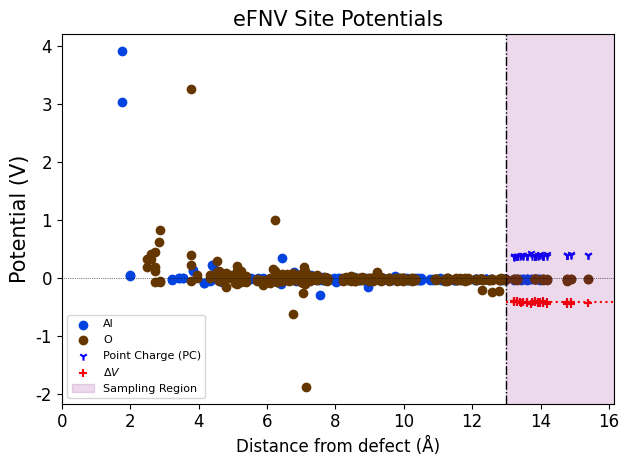

In [26]:
dielectric_tensor = 9.7961 # np.array([[9.5, 0, 0], [0, 9.5, 0], [0, 0, 9.5]])  # you can use dielectric tensor
charge = -1  # Charge state for v_O^-1
result = get_kumagai_correction_from_cube(
    pristine_atoms=pristine_atoms,
    defective_atoms=defective_atoms,
    pristine_potentials=pristine_potentials,
    defective_potentials=defective_potentials,
    valid_matches=valid_matches,
    defect_reference= defect_reference , # defect position
    dielectric=dielectric_tensor,
    charge=charge,
    defect_region_radius=None,  # Try 5.0 or 10.0 if needed
    excluded_indices=defective_excluded,
    verbose=True,
    plot=True,
    filename="kumagai_potential_plot.png"
)